In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## my_PCA

In [2]:
import math
# 参考了网络学堂上助教给出的代码
class my_PCA(object):
    def __init__(self,n_components):
        self.n_components = n_components
    
    def cov_solver(self, data):
        num_samples,num_features=data.shape                 #输入数据形状
        mean=np.mean(data,axis=0)                           #求各特征均值
        data=data-mean[np.newaxis,:]                        #减均值,mean[np.newaxis,:]形状为[1,num_features]
        covariance=data.T.dot(data)/(num_samples-1)         #求协方差矩阵
        eig_values,eig_vectors=np.linalg.eig(covariance)    #计算特征值及特征矩阵 
        tmp_index=np.argsort(-eig_values)                   #从大到小的顺序
        eig_values=eig_values[tmp_index]                    #从大到小排序
        eig_vectors=eig_vectors[:,tmp_index]                #从大到小s
        self.proj_matrix=eig_vectors[:,:self.n_components]       #挑选n_components个向量进行投影
        self.proj_matrix = self.proj_matrix/np.sqrt(eig_values[:self.n_components])  #白化
        
    
    def svd_solver(self, data):
        mean=np.mean(data,axis=0)
        data=data-mean[np.newaxis,:]                                                 #同上操作
        eig_vectors,eig_values,v=np.linalg.svd(data.T)                               #使用numpy中的SVD方法做SVD
        self.proj_matrix=eig_vectors[:,:self.n_components]                           #挑选n_components个向量进行投影
        self.proj_matrix = self.proj_matrix/np.sqrt(eig_values[:self.n_components])  #白化
                                     

    def transform(self, data):
        mean=np.mean(data,axis=0)
        data=data-mean[np.newaxis,:]                       #均值归一化为0
        new_data=data.dot(self.proj_matrix)                #将数据投影到新方向
        return new_data    
        

## Time Test

In [3]:
from time import time
from sklearn.model_selection import train_test_split
data = np.load('ex1.npz')
X = data['X']
y = data['y']

print('Dimension of X:', X.shape)

# 选取前2000维测试
# 参考了sklearn网站上的代码
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
n_components = 150
t0 = time()
pca = my_PCA(n_components=n_components).cov_solver(X_train[:,:2000])
print("cov solver: done in %0.3fs" % (time() - t0))

t0 = time()
pca = my_PCA(n_components=n_components).svd_solver(X_train[:,:2000])
print("SVD solver: done in %0.3fs" % (time() - t0))

Dimension of X: (966, 11750)
cov solver: done in 4.365s
SVD solver: done in 0.479s


主分量分析(PCA)是要找到一组依次反映样本最大方差方向的正交向量P, PCA求解可以通过：
1. 求解原数据矩阵的协方差阵的特征值，按照大小选取前n个特征值对应的特征向量，构成投影矩阵；
2. 也可以通过矩阵奇异值分解(SVD)解决，按照大小选取前n个奇异值对应的左奇异向量，构成投影矩阵。

从运行结果来看，SVD用时更短。暴力求矩阵特征值的时间复杂度是立方复杂度，SVD有成熟的数值求解方法。

## SVM Classification

Extracting the top 150 eigenfaces from 724 faces
Done in 5.365s
Fitting the classifier to the training set
Done in 9.756s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0005)
Test score: 0.8223140495867769
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.70      0.80      0.75        35
           2       0.82      0.70      0.76        20
           3       0.83      0.93      0.87       109
           4       0.87      0.68      0.76        19
           5       1.00      0.71      0.83        17
           6       0.92      0.74      0.82        31

    accuracy                           0.82       242
   macro avg       0.84      0.76      0.79       242
weighted avg       0.83      0.82      0.82       242

Confusion matrix:
 [[  8   2   0   1   0   0   0]
 [  0  28   0   6   0   0   1]
 [  2   1  14   3   0   0   0]
 [  1   5   1 101   1   

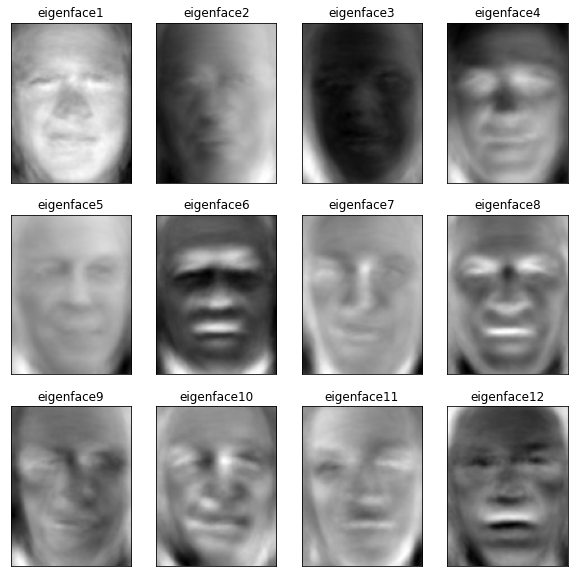

In [5]:

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



n_components = 150

# 先用PCA降维
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
#pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
pca = my_PCA(n_components=n_components)
pca.svd_solver(X_train)
print("Done in %0.3fs" % (time() - t0))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# 寻找SVM最佳参数
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Done in %0.3fs" % (time() - t0))

print("Best estimator found by grid search:")
print(clf.best_estimator_)

# 测试，用三种方法表征结果
y_pred = clf.predict(X_test_pca)
print('Test score:', clf.score(X_test_pca, y_test))
print('Classification report:\n', classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))


# 可视化eigenface
plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(pca.proj_matrix[:,i], (125,94)), cmap=plt.cm.gray)
    plt.title('eigenface{}'.format(i+1))
    plt.xticks(())
    plt.yticks(())

使用PCA降维后，使用SVM分类（gridsearch寻优），在划分出来的测试集上训练效果较好，精度为0.860。
讨论：
1. 这里降维后的维度选取的是150，与sklearn给出的例子中一致，实际中可以适当增大或减小；根据知识和经验，降维后的维度选取存在一个最优值，不能太大也不能太小；同时，维度越小，SVM分类越容易，耗时越短。
2. sklearn给出的例子中提供的PCA类并且设置whiten=True；有一个问题是在使用自己写的my_PCA类时，得到的测试精度很低，约0.3，经过仔细对比发现自己忘记设置了白化操作，查阅了sklearn中的源码及一些资料，用除以对应特征值的平方根的方法归一方差。Whitening will remove some information from the transformed signal (the relative variance scales of the components) but can sometime improve the predictive accuracy of the downstream estimators by making their data respect some hard-wired assumptions.
3. 参考给出的例子，对于分类问题，学到了两种表征结果的方法。第一种是Classification report，给出了对每一类的precision, recall, 和它们的调和平均F1-score；第二种是Confusion matrix，二维数组，更具体地表征了分类的True和False的情况及数量。

## Test

In [61]:
test_data = np.load('test.npz')['X']
test_data_pca = pca.transform(test_data)
test_result = clf.predict(test_data_pca)
np.savetxt("output.txt", test_result.reshape(1, test_result.shape[0]), fmt='%d', delimiter=' ')